# Diffusion of a Gaussian function

Author: Jørgen S. Dokken

Let us now solve a more interesting problem, namely the diffusion of a Gaussian hill. We take the initial value to be 
\begin{align}
    u_0(x,y)&= e^{-ax^2-ay^2}
\end{align}
for $a=5$ on the domain $[-2,-2]\times[2,2]$. For this problem we will use homogeneous Dirichlet boundary conditions ($u_D=0$).

The first difference from the previous problem is that we are not using a unit square. We create the rectangular domain with `dolfinx.RectangleMesh`.

In [1]:
import dolfinx
import numpy as np
from dolfinx.cpp.mesh import CellType
from mpi4py import MPI
from petsc4py import PETSc

# Define temporal parameters
t = 0 # Start time
T = 2.0 # Final time
num_steps = 61     
dt = T / num_steps # time step size

# Define mesh
nx, ny = 50, 50
mesh = dolfinx.RectangleMesh(MPI.COMM_WORLD, [np.array([-2, -2, 0]), np.array([2, 2, 0])], [nx, ny], CellType.triangle)
V = dolfinx.FunctionSpace(mesh, ("CG", 1))

Note that we have used a much higher resolution that before to better resolve features of the solution. 
We also easily update the intial and boundary conditions. Instead of using a class to define the initial condition, we simply use a function

In [2]:
# Create initial condition
def initial_condition(x):
    a = 5
    return np.exp(-a*(x[0]**2+x[1]**2))
u_n = dolfinx.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)
u_n.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

# Create boundary condition
u_D = dolfinx.Function(V)
with u_D.vector.localForm() as loc:
    loc.set(0)
fdim = mesh.topology.dim - 1
boundary_facets = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
bc = dolfinx.DirichletBC(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

## Time-dependent output
To visualize the solution in an external program such as Paraview, we create a an `XDMFFile` which we can store multiple solutions in. The main advantage with an XDMFFile, is that we only need to store the mesh once, and can append multiple solutions to the same grid, reducing the storage space.
The first argument to the XDMFFile is which communicator should be used to store the data. As we would like one output, independent of the number of processors, we use the `COMM_WORLD`. The second argument is the file name of the output file, while the third argument is the state of the file, 
this could be read (`"r"`), write (`"w"`) or append (`"a"`).

In [3]:
from dolfinx.io import XDMFFile
xdmf = XDMFFile(MPI.COMM_WORLD, "diffusion.xdmf", "w")
xdmf.write_mesh(mesh)
# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = dolfinx.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
xdmf.write_function(uh, t)

## Variational problem and solver
As in the previous example, we prepare objects for time dependent problems, such that we do not have to recreate data-structures.

In [4]:
import ufl
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = dolfinx.Constant(mesh, 0)
a = u * v * ufl.dx + dt*ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx 
L = (u_n + dt * f) * v * ufl.dx

## Preparing linear algebra structures for time dependent problems
We observe that the left hand side of the system, the matrix $A$ does not change from one time step to another, thus we only need to assemble it once. However, the right hand side, which is dependent on the previous time step `u_n`, we have to assemble it every time step. Therefore, we only create a vector `b` based on `L`, which we will reuse at every time step.  


In [5]:
A = dolfinx.fem.assemble_matrix(a, bcs=[bc])
A.assemble()
b = dolfinx.fem.create_vector(L)

## Using petsc4py to create a linear solver
As we have already assembled `a` into the matrix `A`, we can no longer use the `dolfinx.fem.LinearProblem` class to solve the problem. Therefore, we create a linear algebra solver using PETSc, and assign the matrix `A` to the solver, and choose the solution strategy.

In [6]:
solver = PETSc.KSP().create(mesh.mpi_comm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## Visualization of time dependent problem using pyvista
We use the dolfin-X plotting functionality, which is based on pyvista to plot the solution at every $15$th time step. We would also like to visualize a colorbar reflecting the minimal and maximum value of $u$ at each time step. We use the following convenience function `plot_function` for this:

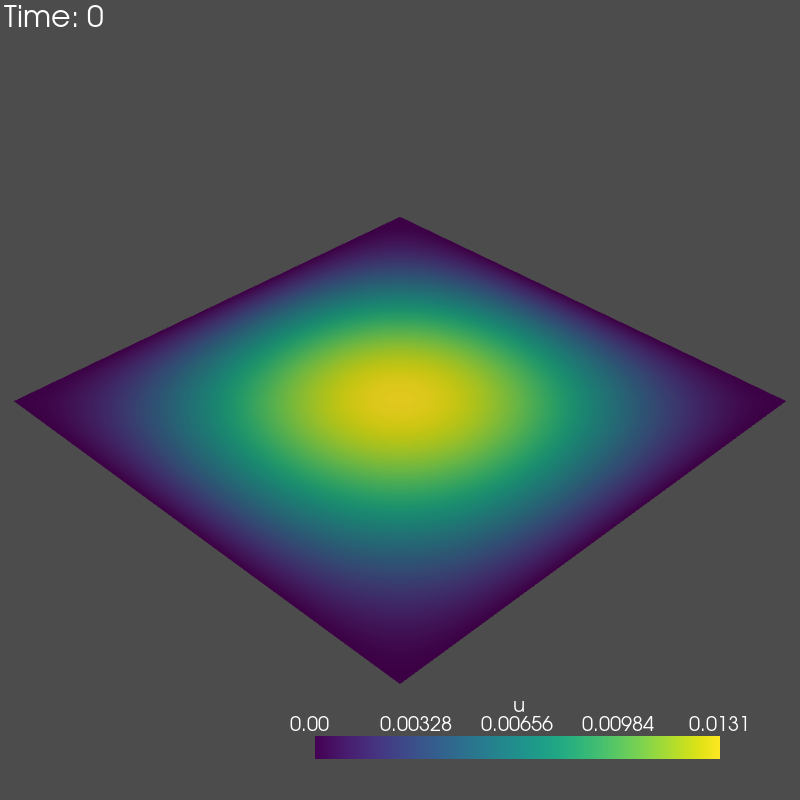

In [10]:
import pyvista
import dolfinx.plot
# Activate framebuffer, required for visualziation
pyvista.start_xvfb(wait=0.05)

# Create background plotter and mesh to attach values to
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter(title="Concentration", window_size=[800, 800])
    # Add time-stamp
    p.add_text(f"Time: {t}", font_size=12, name="timelabel")
    # Update point values on pyvista grid
    grid.point_arrays["u"] = uh.compute_point_values().real
    # Warp mesh by point values
    warped = grid.warp_by_scalar("u", factor=1.5)

    # Add mesh to plotter and visualize in notebook or save as figure
    actor = p.add_mesh(warped)
    if not pyvista.OFF_SCREEN:
       p.show()
    figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
    # Clear plotter for next plot
    p.remove_actor(actor)
plot_function(0, uh)

In [8]:
if not pyvista.OFF_SCREEN:
    plotter_ITK = pyvista.PlotterITK()
    plotter_ITK.add_mesh(grid)
    plotter_ITK.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Updating the solution and right hand side per time step
To be able to solve the variation problem at each time step, we have to assemble the right hand side and apply the boundary condition before calling
`solver.solve(b, uh.vector)`. We start by resetting the values in `b` as we are reusing the vector at every time step. 
The next step is to assemble the vector, calling `dolfinx.fem.assemble(b, L)` which means that we are assemble the linear for `L(v)` into the vector `b`. Note that we do not supply the boundary conditions for assembly, as opposed to the left hand side. 
This is because we want to use lifting to apply the boundary condition, which preserves symmetry of the matrix $A$ if the bilinear form $a(u,v)=a(v,u)$ without Dirichlet boundary conditions.
When we have applied the boundary condition, we can solve the linear system abd update values that are potentially shared between processors.
Finally, before moving to the next time step, we update the solution at the previous time step to the solution at this time step.

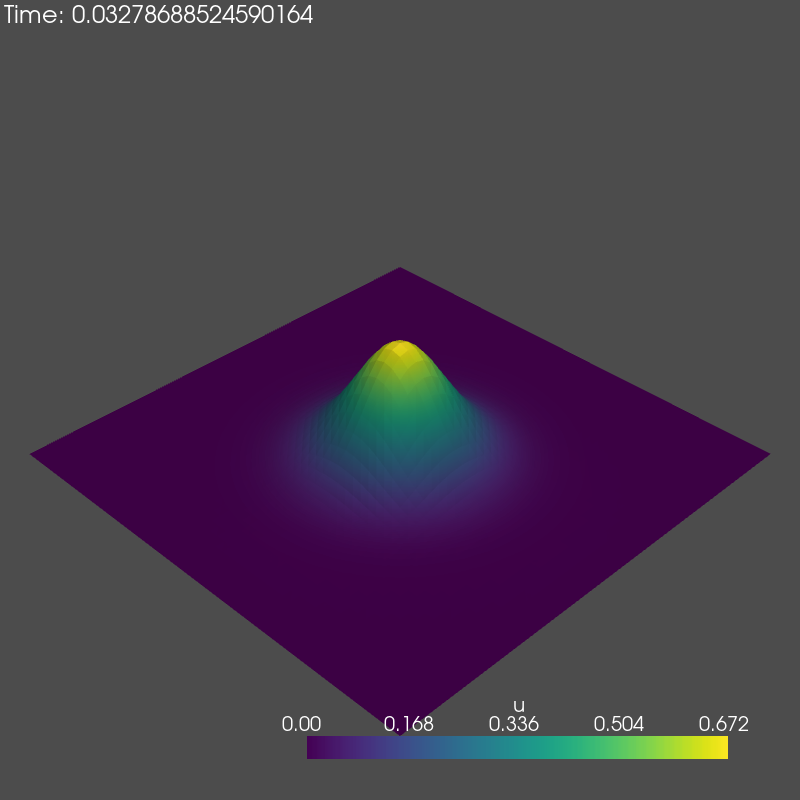

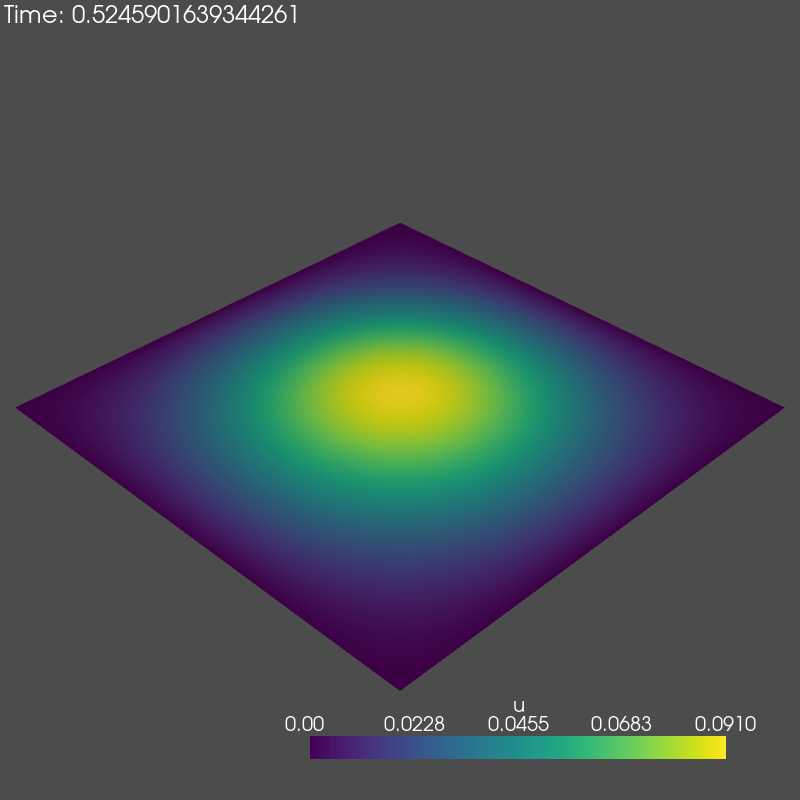

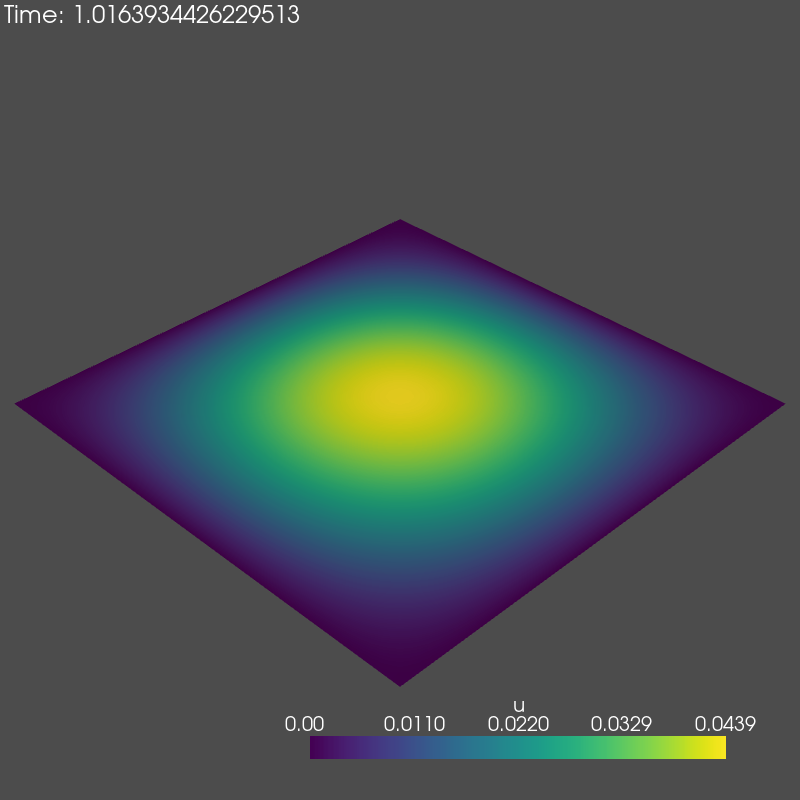

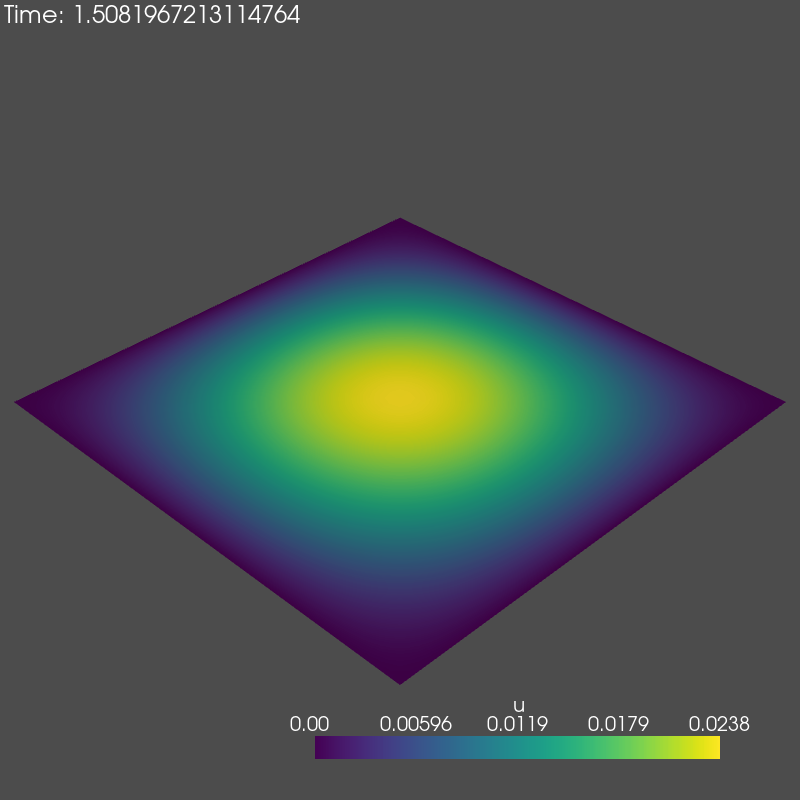

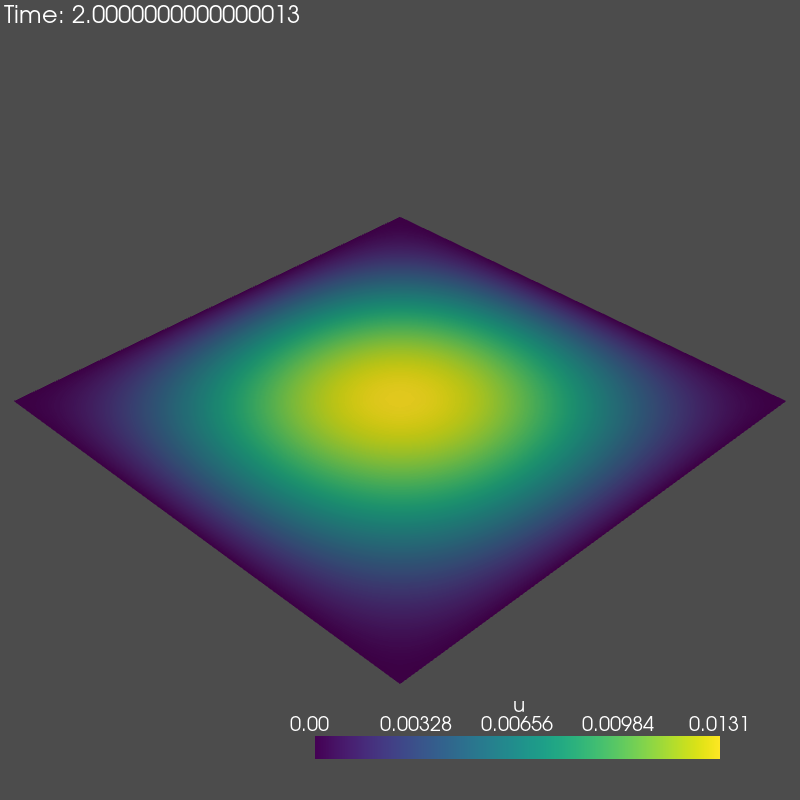

In [9]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    dolfinx.fem.assemble_vector(b, L)
    
    # Apply Dirichlet boundary condition to the vector
    dolfinx.fem.apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)

    # Update solution at previous time step (u_n)
    with uh.vector.localForm() as loc, u_n.vector.localForm() as loc_n:
        loc.copy(result=loc_n)

    # Write solution to file
    xdmf.write_function(uh, t)
    # Plot every 20th time step
    if i % 15 == 0:
        plot_function(t, uh)

xdmf.close()

## Animation with Paraview
We can also use Paraview to create an animation. We open the file in paraview with `File->Open`, and then press `Apply` in the properties panel.

Then, we add a time-annotation to the figure, pressing: `Sources->Alphabetical->Annotate Time` and `Apply` in the properties panel. It Is also a good idea to select an output resolution, by pressing `View->Preview->1280 x 720 (HD)`.

Then finally, click `File->Save Animation`, and save the animation to the desired format, such as `avi`, `ogv` or a sequence of `png`s. Make sure to set the framerate to something, sensible, in the range of $5-10$ frames per second.